### Task 3: Feature Engineering

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import norm

In [2]:
# Load the dataset
data = pd.read_csv('/home/ayalk94/Documents/GitHub/Credit_Scoring/data/data.csv')

###  1. Create Aggregate Features

In [3]:
data['TotalTransactionAmount'] = data.groupby('CustomerId')['Amount'].transform('sum')
data['AverageTransactionAmount'] = data.groupby('CustomerId')['Amount'].transform('mean')
data['TransactionCount'] = data.groupby('CustomerId')['Amount'].transform('count')


### 2. Extract Date and Time Features

In [4]:
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
data['TransactionHour'] = data['TransactionStartTime'].dt.hour
data['TransactionDay'] = data['TransactionStartTime'].dt.day
data['TransactionMonth'] = data['TransactionStartTime'].dt.month
data['TransactionYear'] = data['TransactionStartTime'].dt.year

### 3. Encode Categorical Variables

In [5]:
le = LabelEncoder()
data['ProductCategoryEncoded'] = le.fit_transform(data['ProductCategory'])

### 4. Handle Missing Values

In [6]:
imputer = SimpleImputer(strategy='mean')
data['Amount'] = imputer.fit_transform(data[['Amount']])


### 5. Normalize Numerical Features

In [7]:
scaler = StandardScaler()
data[['Amount', 'TotalTransactionAmount', 'AverageTransactionAmount']] = scaler.fit_transform(
    data[['Amount', 'TotalTransactionAmount', 'AverageTransactionAmount']]
)

In [8]:
# Recency: Days since last transaction
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
latest_date = data['TransactionStartTime'].max()
data['Recency'] = (latest_date - data['TransactionStartTime']).dt.days

# Frequency: Number of transactions per customer
data['Frequency'] = data.groupby('CustomerId')['TransactionId'].transform('count')

# Monetary: Total amount spent per customer
data['Monetary'] = data.groupby('CustomerId')['Amount'].transform('sum')

# Score: Aggregate all components (using simple addition here)
data['RFMS_Score'] = data['Recency'] + data['Frequency'] + data['Monetary']

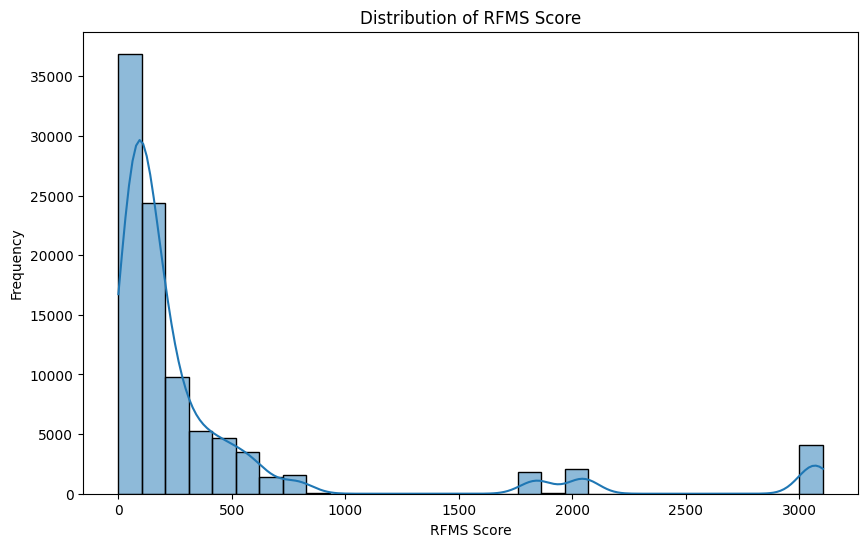

In [12]:
# 2. Visualize the RFMS distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['RFMS_Score'], bins=30, kde=True)
plt.title('Distribution of RFMS Score')
plt.xlabel('RFMS Score')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Establish threshold for Good/Bad classification based on RFMS score
threshold = data['RFMS_Score'].median()  # You can use mean, median or domain-specific threshold

# 3. Assign Good/Bad Label
data['RiskLabel'] = np.where(data['RFMS_Score'] >= threshold, 'Good', 'Bad')


### Step 2: Weight of Evidence (WoE) Binning

###  1. Discretize RFMS_Score for WoE Binning

In [25]:
# Discretize RFMS_Score for WoE Binning
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
data['RFMS_Bin'] = est.fit_transform(data[['RFMS_Score']])


### 2. Calculate WoE for each bin

In [41]:
def calculate_woe(df, target_column, bin_column):
    total_good = df[target_column].value_counts().get('Good', 0)
    total_bad = df[target_column].value_counts().get('Bad', 0)
    woe_records = []
    
    for b in sorted(df[bin_column].unique()):
        bin_data = df[df[bin_column] == b]
        good = len(bin_data[bin_data[target_column] == 'Good']) + 0.5
        bad = len(bin_data[bin_data[target_column] == 'Bad']) + 0.5
        dist_good = good / (total_good + 0.5)
        dist_bad = bad / (total_bad + 0.5)
        woe = np.log(dist_good / dist_bad) if dist_bad > 0 else 0
        woe_records.append({'Bin': b, 'WoE': woe})
    
    woe_df = pd.DataFrame(woe_records)
    return woe_df



In [42]:
woe_df = calculate_woe(data, 'RiskLabel', 'RFMS_Bin')
print(woe_df)


   Bin       WoE
0  0.0 -9.859504
1  1.0 -9.860445
2  2.0 -9.859923
3  3.0 -9.859818
4  4.0 -9.858144
5  5.0  9.860297
6  6.0  9.858417
7  7.0  9.857894
8  8.0  9.853597
9  9.0  9.863838


### Step 3: Integrate WoE Encodings into the Model

### Visualizing WoE

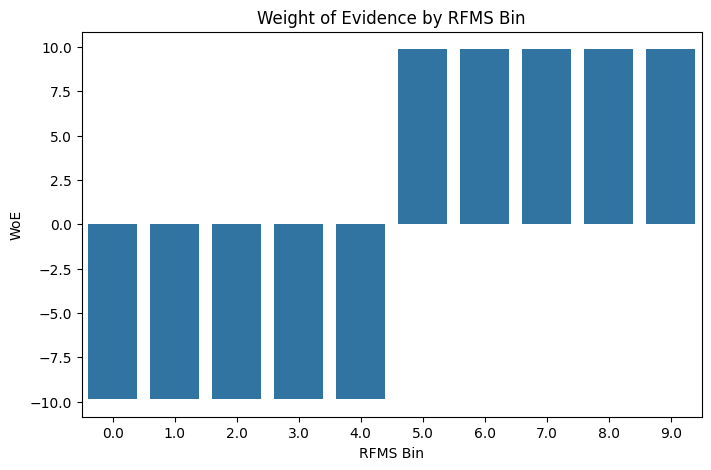

In [43]:
# Visualize WoE values
plt.figure(figsize=(8, 5))
sns.barplot(data=woe_df, x='Bin', y='WoE')
plt.title('Weight of Evidence by RFMS Bin')
plt.xlabel('RFMS Bin')
plt.ylabel('WoE')
plt.show()